# **Homework 4_1**

Выполнил: Касенов Султан

В данной лабораторной работе мы обучим нейросеть классифицировать породы кошек и собак. Сначала скачаем наш датасет изображений. 

Спроси про топ 3, про точность, как за тестить фотку, размер. 
Нету нормализации. 
Узнай про бин классфификацию


In [ ]:
!wget http://www.soshnikov.com/permanent/data/petfaces.tar.gz
!tar xvfz petfaces.tar.gz

Импортируем все используемые библиотеки в данной работе. 

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sn
import pandas as pd
from PIL import Image



# **Породы кошек и собак**

Наши изображения разделены на классы (породы) и каждая порода кошки или собаки лежит в своей соответствующей папке. Однако нам нужно разделить изображения на обучающие и тестовые. Для этого мы создаем новые директории test и train. Далее распределяем 80 процентов изображений в папку train и 20 в test. 

In [ ]:
# Set the path to the directory containing the class directories
data_dir = './petfaces'

# Get a list of the class directories
class_dirs = os.listdir(data_dir)

# Loop through each class directory and split the images into training and testing sets
for class_dir in class_dirs:
    # Set the path to the current class directory
    class_path = os.path.join(data_dir, class_dir)
    
    # Get a list of the image files in the class directory
    image_files = os.listdir(class_path)
    
    # Split the image files into training and testing sets
    train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
    
    # Create new directories for the training and testing sets
    train_dir = os.path.join(data_dir, 'train', class_dir)
    test_dir = os.path.join(data_dir, 'test', class_dir)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Move the training images to the new directory
    for train_file in train_files:
        src_path = os.path.join(class_path, train_file)
        dst_path = os.path.join(train_dir, train_file)
        shutil.copy(src_path, dst_path)
        
    # Move the testing images to the new directory
    for test_file in test_files:
        src_path = os.path.join(class_path, test_file)
        dst_path = os.path.join(test_dir, test_file)
        shutil.copy(src_path, dst_path)

Подготавливаем dataloaders и функцию предобработки которая будет выполняться для каждого батча. Также сохраняем классы в новую переменную. 

In [ ]:
# define transform functions which should applied to images
transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# prepare loader for train data
trainset = torchvision.datasets.ImageFolder(root='./petfaces/train', transform=transform )
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)

# prepare loader for test data
testset = torchvision.datasets.ImageFolder(root='./petfaces/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)

# save all classes to list
classes = class_dirs


Далее, отсортируем список классов (чтобы был такой же порядок как и в директориях) и сохраним их в виде кортежа. 

In [ ]:
classes.sort()
classes = tuple(classes)
classes

 Пропишем функции *validate* и *train*. Первая нужна чтобы выводить точность нейросети на тестовом датасете, второй метод запускает циклы обучения нейросети. 

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f'Using device={device}')

def validate(net,test_loader):
  count=acc=0
  for xo,yo in test_loader:
    x,y = xo.to(device), yo.to(device)
    with torch.no_grad():
      p = net.forward(x)
      _,predicted = torch.max(p,1)
      acc+=(predicted==y).sum()
      count+=len(x)
  return acc/count

def train(net,train_loader,test_loader,epochs=3,loss_fn=torch.nn.CrossEntropyLoss()):
  net = net.to(device)
  optimizer = torch.optim.Adam(net.parameters())
  for ep in range(epochs):
    count=acc=0
    for xo,yo in train_loader:
      x = xo.to(device)
      y = yo.to(device)
      optimizer.zero_grad()
      p = net.forward(x)
      loss = loss_fn(p,y)
      loss.backward()
      optimizer.step()
      _,predicted = torch.max(p,1)
      acc+=(predicted==y).sum()
      count+=len(x)
    val_acc = validate(net,test_loader)
    print(f"Epoch={ep}, train_acc={acc/count}, val_acc={val_acc}")



Using device=cuda


Ниже представлена архитектура сверточной нейросети, которая будет использоваться в данной работе. Сначала идет слой свертки 3 на 3, имеющий 32 фильтра. Также мы используем функцию активации (Relu) и наконец MaxPooling. После данного слоя мы используем dropout чтобы снизить риск переобучения. Далее идут еще два слоя, почти точно такие же, только повышается кол-во филтров. В конце идет полносвязный линейный слой. 

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.25)
        self.dropout1 = nn.Dropout(0.3)
        self.flat = nn.Flatten()
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, 35)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.dropout1(x)
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
if torch.cuda.is_available():
    net.cuda()

summary(net,input_size=(3, 64, 64))


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 62]             896
         MaxPool2d-2           [-1, 32, 31, 31]               0
           Dropout-3           [-1, 32, 31, 31]               0
            Conv2d-4           [-1, 64, 29, 29]          18,496
         MaxPool2d-5           [-1, 64, 14, 14]               0
           Dropout-6           [-1, 64, 14, 14]               0
            Conv2d-7          [-1, 128, 12, 12]          73,856
         MaxPool2d-8            [-1, 128, 6, 6]               0
           Dropout-9            [-1, 128, 6, 6]               0
          Flatten-10                 [-1, 4608]               0
           Linear-11                  [-1, 128]         589,952
           Linear-12                   [-1, 35]           4,515
Total params: 687,715
Trainable params: 687,715
Non-trainable params: 0
-------------------------------

Запустим цикл обучения нейросети. Лучший результат на тестовом датасете равен 46 процентам.

In [ ]:
train(net, trainloader, testloader, 8)

Epoch=0, train_acc=0.08369182795286179, val_acc=0.1345565766096115
Epoch=1, train_acc=0.2276104837656021, val_acc=0.29204893112182617
Epoch=2, train_acc=0.3738756477832794, val_acc=0.38379207253456116
Epoch=3, train_acc=0.46969103813171387, val_acc=0.428134560585022
Epoch=4, train_acc=0.5314822196960449, val_acc=0.4525994062423706
Epoch=5, train_acc=0.6061791181564331, val_acc=0.4571865499019623
Epoch=6, train_acc=0.6480250358581543, val_acc=0.47706422209739685
Epoch=7, train_acc=0.6855690479278564, val_acc=0.4571865499019623


Теперь для лучшей оценки точности построим матрицу ошибки. Кол-во угаданных правильно классов сильно меняется. Это связано с тем, что для некоторых пород, фотографий было больше чем для других. Также следует отметить, что точность очень низкая и требует построения более сложной архитектуры нейросети.

<Axes: >

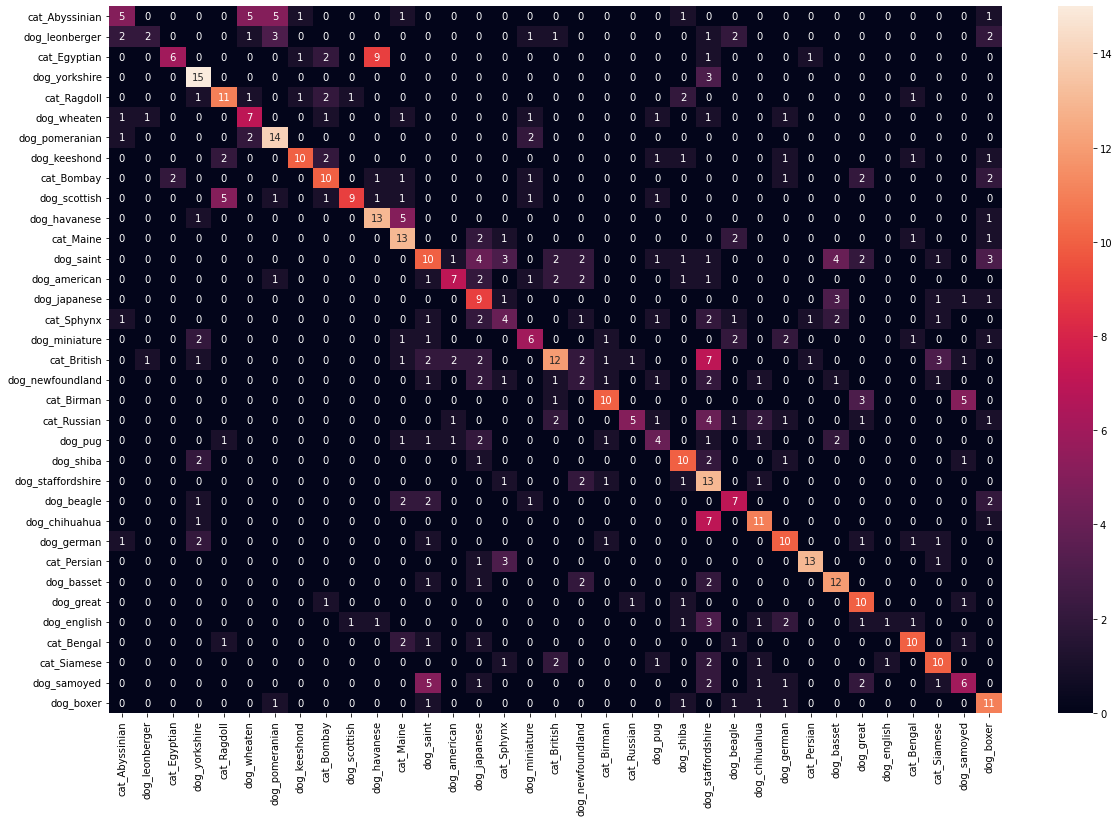

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
  
        output = net(inputs.type(torch.cuda.FloatTensor)) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (20,13))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')

Теперь чтобы предсказывать породы кошек и собак по фотографиям напишем две функции. Первая будет приводить фото в тензор нужного размера и нормализовывать. Вторая будет подавать тензор нейросети и на основе предсказания модели выводить топ 3 породы, на которые похожа кошка или собака.

<ipython-input-6-e5ac22903768>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).type(torch.cuda.FloatTensor)


image--reshape torch.Size([1, 3, 64, 64])


tensor([[[[-0.5922, -0.5059, -0.3961,  ..., -0.2157, -0.2392, -0.3333],
          [-0.4275, -0.4039, -0.4431,  ..., -0.1373, -0.1294, -0.2549],
          [-0.2863, -0.4118, -0.4745,  ..., -0.2706, -0.1765, -0.2392],
          ...,
          [ 0.7255,  0.7412,  0.7412,  ..., -0.1608, -0.2549, -0.2471],
          [ 0.6784,  0.7098,  0.7490,  ..., -0.1686, -0.2784, -0.2471],
          [ 0.6941,  0.7333,  0.7647,  ...,  0.0118, -0.2078, -0.2784]],

         [[-0.6863, -0.6078, -0.4902,  ..., -0.3098, -0.3333, -0.4353],
          [-0.5137, -0.5059, -0.5373,  ..., -0.2157, -0.2000, -0.3255],
          [-0.3725, -0.5137, -0.5686,  ..., -0.3176, -0.2235, -0.2863],
          ...,
          [ 0.5922,  0.6078,  0.6078,  ..., -0.2549, -0.3569, -0.3804],
          [ 0.5451,  0.5765,  0.6157,  ..., -0.2627, -0.3804, -0.3882],
          [ 0.5608,  0.6000,  0.6314,  ..., -0.0824, -0.3098, -0.4196]],

         [[-0.7961, -0.7412, -0.6392,  ..., -0.5843, -0.6078, -0.7098],
          [-0.6471, -0.6392, -

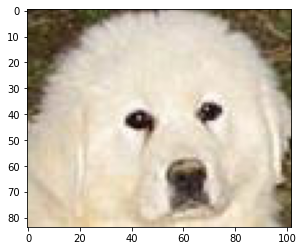

In [ ]:
def image_prep(img_path):

  # read the image
  image = Image.open(img_path)
  
  # plot the image
  plt.imshow(image)

  # apply transform functions
  image = transform(image)

  # convert to tensor and add 1 dimension to create batch with size = 1
  image = torch.tensor(image).type(torch.cuda.FloatTensor)
  image = image[None, :, :, :]
  print("image--reshape",image.shape)
  return image

image_prep('./petfaces/test/dog_great/great_pyrenees_10.jpg')

In [ ]:
def predict(model, img_path, classes):
  # preprocessing image
  img = image_prep(img_path)

  # predict classes
  pred = model.forward(img)

  # find top 3 values
  indices = torch.topk(pred.flatten(), 3).indices
  
  # create and return list with classes
  top_3 = [classes[x] for x in indices]
  return top_3


top3 = predict(net, './petfaces/test/dog_pug/pug_101.jpg', classes)
print('\n_____top 3_____\n')
for c in top3:
  print(c)
  

FileNotFoundError: ignored

# **Кошки или собаки**

Несмотря на то что точность оставляет желать лучшего, попробуем теперь предсказывать не породы, а принадлежность к классу кошек или собак. Для этого создадим новые директории с именами: train_bin, test_bin. Далее распределим 80 процентов кошек и собак по двум соответсвтующим папкам (сats and dogs) внутри дирректории train_bin. Остальную часть кошек и собак в test_bin.

In [ ]:
# create directoiries for train and test data
dog_dir_train = os.path.join(data_dir, 'train_bin', 'dogs')
os.makedirs(dog_dir_train, exist_ok=True)

cat_dir_train = os.path.join(data_dir, 'train_bin', 'cats')
os.makedirs(cat_dir_train, exist_ok=True)

dog_dir_test = os.path.join(data_dir, 'test_bin', 'dogs')
os.makedirs(dog_dir_test, exist_ok=True)

cat_dir_test = os.path.join(data_dir, 'test_bin', 'cats')
os.makedirs(cat_dir_test, exist_ok=True)

# Loop through each class directory and split the images into training and testing sets
for class_dir in class_dirs:    
    # Set the path to the current class directory
    class_path = os.path.join(data_dir, class_dir)

    # skip created directories from the previous part 
    if 'train' in class_path or 'test' in class_path:
      continue

    # Get a list of the image files in the class directory
    image_files = os.listdir(class_path)

    # Split the image files into training and testing sets
    train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)


    # move images to train or test direcotries
    if 'dog' in class_dir:
      for img in train_files:
          src_path = os.path.join(class_path, img)
          shutil.copy(src_path, dog_dir_train)

      for img in test_files:
          src_path = os.path.join(class_path, img)
          shutil.copy(src_path, dog_dir_test)
    else:
      for img in train_files:
          src_path = os.path.join(class_path, img)
          shutil.copy(src_path, cat_dir_train)

      for img in test_files:
          src_path = os.path.join(class_path, img)
          shutil.copy(src_path, cat_dir_test)

Теперь делаем все тоже самое, что и в первой части.


1.   Создаем объекты dataLoaders, которые будут загружать фотографии в нейросеть.
2.   Строим архитектуру нейросети в которой меняется кол-во конечных выходов с 35 до 2 (т.к. используется бинарная классификация).
3.   Обучаем и строим матрицу ошибки новой нейросети.


In [ ]:
# prepare loader for the train data
trainset = torchvision.datasets.ImageFolder(root='./petfaces/train_bin', transform=transform )
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)

# prepare loader for the test data
testset = torchvision.datasets.ImageFolder(root='./petfaces/test_bin', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)

# save all classes in the tuple
classes = ('cats', 'dogs')

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.25)
        self.dropout1 = nn.Dropout(0.3)
        self.flat = nn.Flatten()
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.dropout1(x)
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
if torch.cuda.is_available():
    net.cuda()

summary(net,input_size=(3, 64, 64))

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 62]             896
         MaxPool2d-2           [-1, 32, 31, 31]               0
           Dropout-3           [-1, 32, 31, 31]               0
            Conv2d-4           [-1, 64, 29, 29]          18,496
         MaxPool2d-5           [-1, 64, 14, 14]               0
           Dropout-6           [-1, 64, 14, 14]               0
            Conv2d-7          [-1, 128, 12, 12]          73,856
         MaxPool2d-8            [-1, 128, 6, 6]               0
           Dropout-9            [-1, 128, 6, 6]               0
          Flatten-10                 [-1, 4608]               0
           Linear-11                  [-1, 128]         589,952
           Linear-12                    [-1, 2]             258
Total params: 683,458
Trainable params: 683,458
Non-trainable params: 0
-------------------------------

In [ ]:
train(net, trainloader, testloader, 5)

Epoch=0, train_acc=0.6679702997207642, val_acc=0.7614679336547852
Epoch=1, train_acc=0.836918294429779, val_acc=0.8302752375602722
Epoch=2, train_acc=0.8787642121315002, val_acc=0.9082568883895874
Epoch=3, train_acc=0.9065310955047607, val_acc=0.8822630047798157
Epoch=4, train_acc=0.9186546802520752, val_acc=0.9067278504371643


Для бинарной классификации результаты оказались намного лучше (около 93 процентов). Также построим матрицу ошибок.

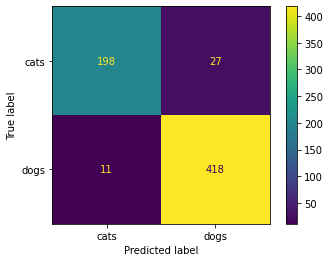

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
  
        output = net(inputs.type(torch.cuda.FloatTensor)) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])

disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                              display_labels=classes)

disp.plot()
